# Canary testing tri-QQ plots

Try to detect single nodes that might be different.

Note that this uses anti-beacons: clients that ran tests during the canary, but ran fewer than 10 tests over the preceding year.


In [1]:
import math
import pandas as pd
import BQhelper as bq
import matplotlib.pyplot as plt

bq.project = "mlab-sandbox"

In [13]:

antiBeaconQ="""
WITH

# Find clinets that ran <10 test in the past year but >0 tests in the target date range
antiBeacons AS (
SELECT
  client.IP,
  count(*) AS AnnualTests,
  COUNTIF( test_date > '2020-06-11' ) AS CanryTests
FROM `measurement-lab.library.ndt_unified_ndt5_{direction}`
WHERE
  test_date > '2019-06-16' 
  {where}
GROUP BY client.IP
HAVING
  CanryTests > 0 AND AnnualTests < 10
),

# Get all tests for the above clients in the target date range
antiBeaconTSG AS (
SELECT
  a.testTime,
  a.MeanThroughputMbps,
  REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, '(mlab[1-4]-[a-z][a-z][a-z][0-9][0-9t])') AS shortname
FROM (  SELECT client.IP as IP, *
        FROM `measurement-lab.library.ndt_unified_ndt5_{direction}`
        WHERE filter.IsValidBest ) JOIN antiBeacons USING ( IP )
WHERE
  test_date > '2020-06-11' 
  {where}
),

ServerMedians AS (
  SELECT shortname,
  APPROX_QUANTILES(MeanThroughputMbps, 100)[OFFSET(50)] AS pctl_50,
  APPROX_QUANTILES(MeanThroughputMbps, 100)[OFFSET(95)] AS pctl_95
FROM antiBeaconTSG 
GROUP BY ShortName
ORDER BY pctl_95
),

ServerQuants AS (
SELECT
    shortname,
    APPROX_QUANTILES(MeanThroughputMbps, 100) AS quants,
    count(*) As tests,
FROM antiBeaconTSG
GROUP BY ShortName
)

SELECT * FROM {subquery}

"""

metros = "AND REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, 'mlab[1-4]-([a-z][a-z][a-z])[0-9][0-9t]') IN ({metros})"
# data=bq.DataFrameQuery(antiBeaconQ, subquery='ServerMedians', metro='lga', direction='download')


In [3]:


def TriQQ(quantiles):
    quants={}
    tests={}
    for row, q, t in zip(quantiles['shortname'], quantiles['quants'], quantiles['tests']):
        quants[row] = q
        tests[row] = t
    sites=[]
    for s in sorted(quantiles['shortname']):
        if 'mlab1' not in s:
            break
        sites.append(s[-5:])
    columns = 3
    rows = math.ceil(len(quantiles) / float(columns))
    plt.rcParams['figure.figsize'] = [20,4*rows]
    
    for row, site in enumerate(sites):
        for col in range(3):
            current = plt.subplot(rows, columns, row*3+col+1)
            x='mlab%d-%s'%(col+1, site)
            y='mlab%d-%s'%((col+1)%3+1, site)
            lo, hi = 0.01, 2000
            plt.loglog([lo,hi],[lo,hi],color='lightgray')
            if x in quants and y in quants:
                plt.loglog(quants[x], quants[y],linewidth=0, marker=".", markersize=7)
            plt.title('%s(%d) %s'%(x,tests[x],y))

In [4]:
quantiles=bq.DataFrameQuery(antiBeaconQ, subquery='ServerQuants', where=metros, metros='"gru"', direction='download')

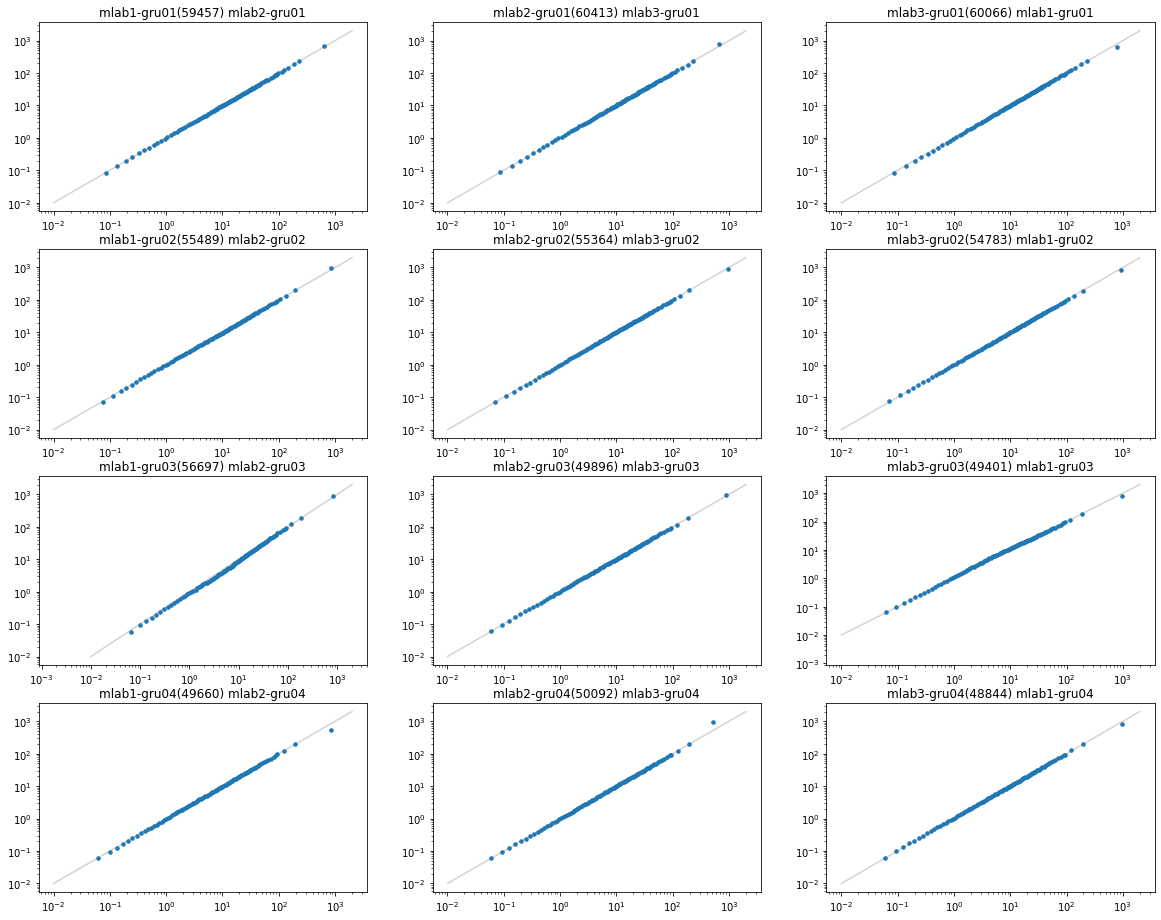

In [5]:
TriQQ(quantiles)

In [6]:
odd=bq.DataFrameQuery(antiBeaconQ, subquery='ServerQuants', where=metros, metros='"arn", "tnr"', direction='download')

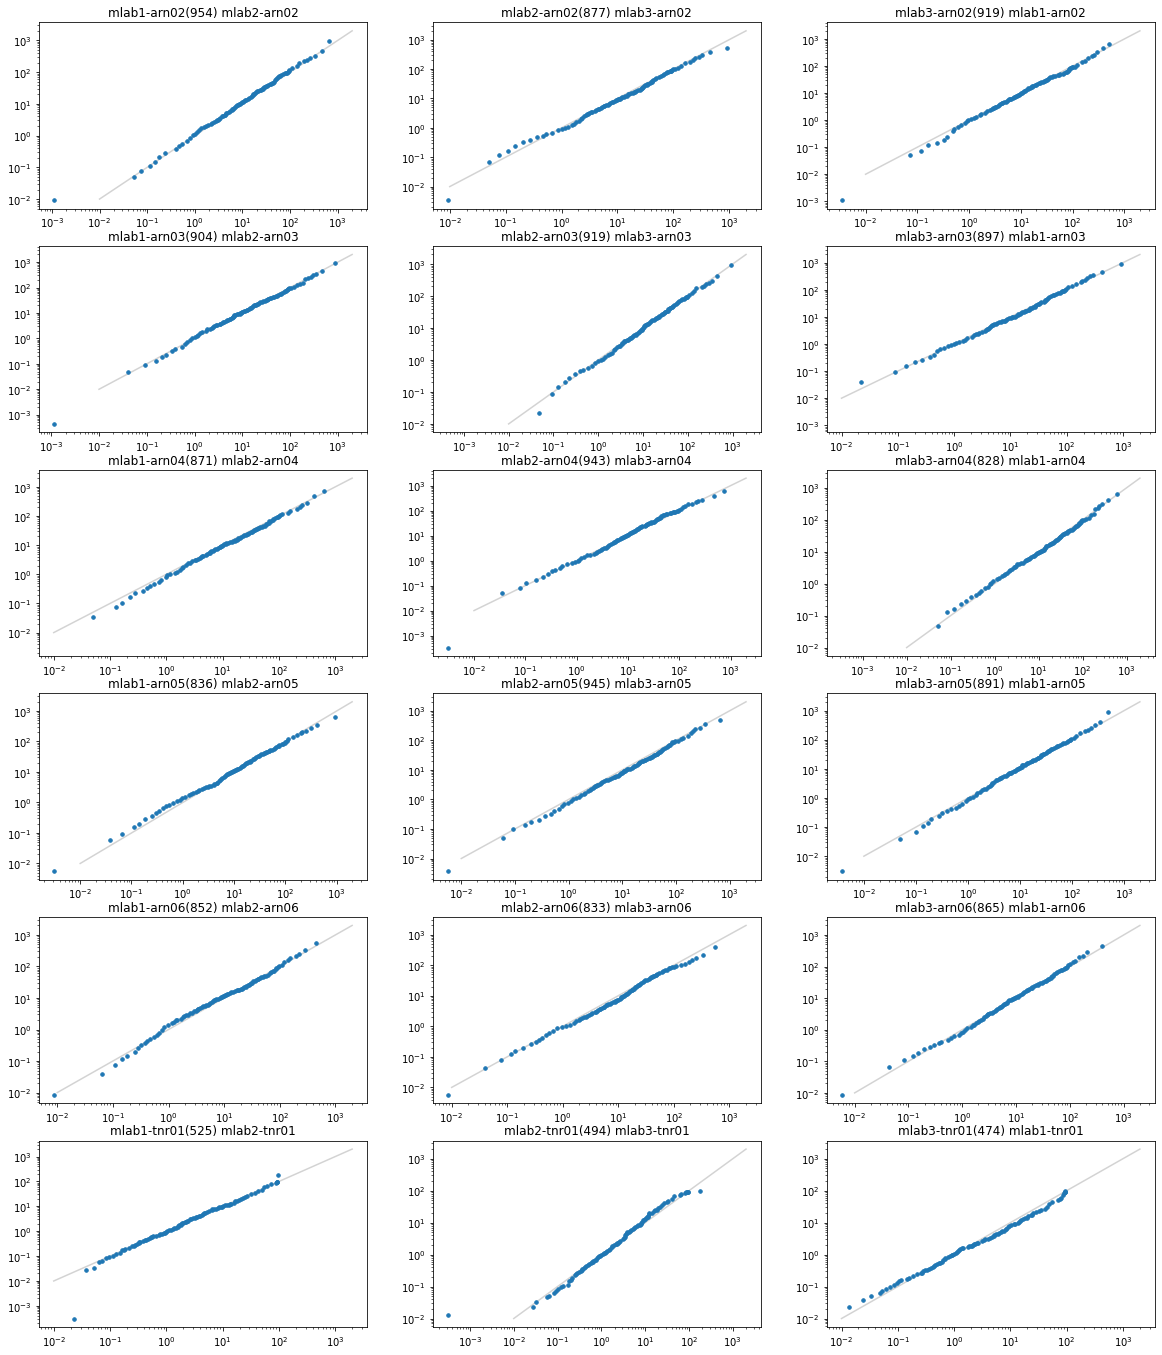

In [7]:
TriQQ(odd)

In [8]:
# Global works, but takes a long time and yields a 30k px tall image
# GlobalQuants=bq.DataFrameQuery(antiBeaconQ, subquery='ServerQuants', where='', direction='download')
# TriQQ(GlobalQuants)

## Upload Tests

In [18]:
lgaUp=bq.DataFrameQuery(antiBeaconQ, subquery='ServerQuants', where=metros, metros='"lga"', direction='uploads')

400 Field name ParseInfo does not exist in STRUCT<partition_date DATE, C2S STRUCT<ServerIP STRING, ServerPort INT64, ClientIP STRING, ...>, b_HasError BOOL, ...> at [13:38]

(job ID: 7748e702-26a5-4cc0-89cd-c05052538a1c)

                                           -----Query Job SQL Follows-----                                            

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:WITH
   3:
   4:# Find clinets that ran <10 test in the past year but >0 tests in the target date range
   5:antiBeacons AS (
   6:SELECT
   7:  client.IP,
   8:  count(*) AS AnnualTests,
   9:  COUNTIF( test_date > '2020-06-11' ) AS CanryTests
  10:FROM `measurement-lab.library.ndt_unified_ndt5_uploads`
  11:WHERE
  12:  test_date > '2019-06-16' 
  13:  AND REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, 'mlab[1-4]-([a-z][a-z][a-z])[0-9][0-9t]') IN ("lga")
  14:GROUP BY client.IP
  15:HAVING
  16:  CanryTests > 0 AND 

BadRequest: 400 Field name ParseInfo does not exist in STRUCT<partition_date DATE, C2S STRUCT<ServerIP STRING, ServerPort INT64, ClientIP STRING, ...>, b_HasError BOOL, ...> at [13:38]

(job ID: 7748e702-26a5-4cc0-89cd-c05052538a1c)

                                           -----Query Job SQL Follows-----                                            

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:WITH
   3:
   4:# Find clinets that ran <10 test in the past year but >0 tests in the target date range
   5:antiBeacons AS (
   6:SELECT
   7:  client.IP,
   8:  count(*) AS AnnualTests,
   9:  COUNTIF( test_date > '2020-06-11' ) AS CanryTests
  10:FROM `measurement-lab.library.ndt_unified_ndt5_uploads`
  11:WHERE
  12:  test_date > '2019-06-16' 
  13:  AND REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, 'mlab[1-4]-([a-z][a-z][a-z])[0-9][0-9t]') IN ("lga")
  14:GROUP BY client.IP
  15:HAVING
  16:  CanryTests > 0 AND AnnualTests < 10
  17:),
  18:
  19:# Get all tests for the above clients in the target date range
  20:antiBeaconTSG AS (
  21:SELECT
  22:  a.testTime,
  23:  a.MeanThroughputMbps,
  24:  REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, '(mlab[1-4]-[a-z][a-z][a-z][0-9][0-9t])') AS shortname
  25:FROM (  SELECT client.IP as IP, *
  26:        FROM `measurement-lab.library.ndt_unified_ndt5_uploads`
  27:        WHERE filter.IsValidBest ) JOIN antiBeacons USING ( IP )
  28:WHERE
  29:  test_date > '2020-06-11' 
  30:  AND REGEXP_EXTRACT(_internal202004.ParseInfo.TaskFileName, 'mlab[1-4]-([a-z][a-z][a-z])[0-9][0-9t]') IN ("lga")
  31:),
  32:
  33:ServerMedians AS (
  34:  SELECT shortname,
  35:  APPROX_QUANTILES(MeanThroughputMbps, 100)[OFFSET(50)] AS pctl_50,
  36:  APPROX_QUANTILES(MeanThroughputMbps, 100)[OFFSET(95)] AS pctl_95
  37:FROM antiBeaconTSG 
  38:GROUP BY ShortName
  39:ORDER BY pctl_95
  40:),
  41:
  42:ServerQuants AS (
  43:SELECT
  44:    shortname,
  45:    APPROX_QUANTILES(MeanThroughputMbps, 100) AS quants,
  46:    count(*) As tests,
  47:FROM antiBeaconTSG
  48:GROUP BY ShortName
  49:)
  50:
  51:SELECT * FROM ServerQuants
  52:
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |

In [ ]:
TriQQ(lgaUp)

In [ ]:
GlobalUpload=bq.DataFrameQuery(antiBeaconQ, subquery='ServerQuants', where='', direction='upload')

In [ ]:
TriQQ(GlobalUpload)